In [10]:
# Pluto–Tasche method on "Give Me Some Credit"
# --------------------------------------------
# 1. Download GMSC dataset (if not present)
# 2. Prepare a high-score / low-default cohort
# 3. Apply Pluto–Tasche confidence bound for PD
# 4. Evaluate coverage by backtest

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Step 1: Load your local dataset
# Replace with your actual path if needed
df = pd.read_csv("cs-training.csv")

print("Dataset shape:", df.shape)
print("Default rate (overall):", df['SeriousDlqin2yrs'].mean())



Dataset shape: (150000, 12)
Default rate (overall): 0.06684


In [11]:
# Step 2: Define a score proxy for "creditworthiness"
# Simple linear combo of available features

df['score_proxy'] = (
    0.3*np.log1p(df['MonthlyIncome'].fillna(0)) +
    0.2*(df['age']) -
    0.5*(df['NumberOfTimes90DaysLate'])
)

# Select top 5% as low-default portfolio
threshold = np.percentile(df['score_proxy'], 95)
cohort = df[df['score_proxy'] >= threshold]

n = len(cohort)
k = cohort['SeriousDlqin2yrs'].sum()

print(f"Cohort size: {n}, Defaults: {k}, Raw default rate: {k/n:.4f}")


Cohort size: 7500, Defaults: 158, Raw default rate: 0.0211


In [12]:
# Step 3: Pluto–Tasche upper bound calculation
def pluto_tasche_bound(n, k, alpha=0.001):
    if k == 0:
        return 1 - alpha**(1/n)
    else:
        return beta.ppf(1 - alpha, k+1, n-k)

pt_bound = pluto_tasche_bound(n, k, alpha=0.001)
print(f"Pluto–Tasche PD upper bound (99.9% conf): {pt_bound:.4f}")


Pluto–Tasche PD upper bound (99.9% conf): 0.0267


Coverage frequency vs true PD (simulated): 0.999


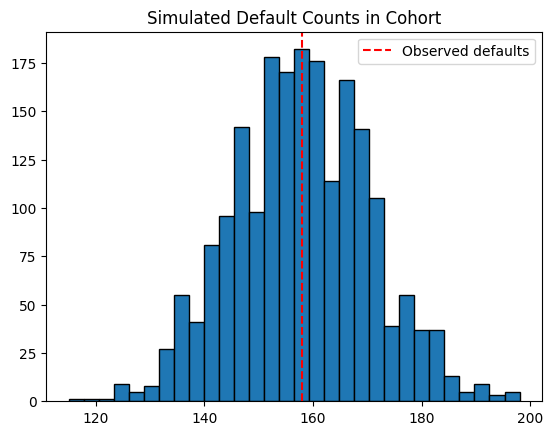

In [13]:
# Step 4: Backtest simulation
true_pd = k/n if k>0 else 0.001
sim_runs = 2000
counts = np.random.binomial(n, true_pd, size=sim_runs)

covered = np.mean([pluto_tasche_bound(n, c, 0.001) >= true_pd for c in counts])
print(f"Coverage frequency vs true PD (simulated): {covered:.3f}")

plt.hist(counts, bins=30, edgecolor='k')
plt.axvline(k, color='r', linestyle='--', label="Observed defaults")
plt.title("Simulated Default Counts in Cohort")
plt.legend()
plt.show()


Perfect — here’s the extended Pluto–Tasche notebook using your cs-training.csv.
This adds:

- Naïve PD estimate (k/n)

- Clopper–Pearson exact confidence interval (binomial)

- Pluto–Tasche upper bound side by side

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, binomtest

# Step 1: Load dataset
df = pd.read_csv("cs-training.csv")

print("Dataset shape:", df.shape)
print("Default rate (overall):", df['SeriousDlqin2yrs'].mean())

# Step 2: Define a score proxy for "creditworthiness"
df['score_proxy'] = (
    0.3*np.log1p(df['MonthlyIncome'].fillna(0)) +
    0.2*(df['age']) -
    0.5*(df['NumberOfTimes90DaysLate'])
)

# Select top 5% as low-default portfolio
threshold = np.percentile(df['score_proxy'], 95)
cohort = df[df['score_proxy'] >= threshold]

n = len(cohort)
k = cohort['SeriousDlqin2yrs'].sum()

print(f"Cohort size: {n}, Defaults: {k}, Raw default rate: {k/n:.4f}")


Dataset shape: (150000, 12)
Default rate (overall): 0.06684
Cohort size: 7500, Defaults: 158, Raw default rate: 0.0211


In [15]:
# Step 3: Pluto–Tasche upper bound
def pluto_tasche_bound(n, k, alpha=0.001):
    if k == 0:
        return 1 - alpha**(1/n)
    else:
        return beta.ppf(1 - alpha, k+1, n-k)

pt_bound = pluto_tasche_bound(n, k, alpha=0.001)


In [16]:
# Step 4: Clopper–Pearson confidence interval
# Using scipy's binomtest to get exact CI
alpha = 0.001
ci = binomtest(k, n).proportion_ci(confidence_level=1-alpha, method="exact")

naive_pd = k/n
lower_cp, upper_cp = ci.low, ci.high

print(f"Naive PD: {naive_pd:.6f}")
print(f"Clopper-Pearson 99.9% CI: [{lower_cp:.6f}, {upper_cp:.6f}]")
print(f"Pluto–Tasche 99.9% upper bound: {pt_bound:.6f}")


Naive PD: 0.021067
Clopper-Pearson 99.9% CI: [0.016024, 0.027089]
Pluto–Tasche 99.9% upper bound: 0.026701


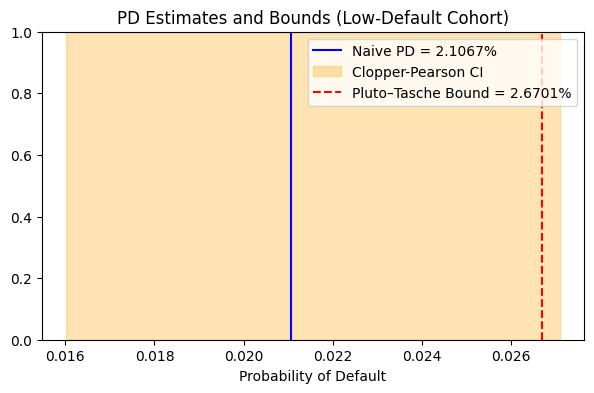

In [17]:
# Step 5: Compare all three visually
plt.figure(figsize=(7,4))
plt.axvline(naive_pd, color="blue", label=f"Naive PD = {naive_pd:.4%}")
plt.axvspan(lower_cp, upper_cp, color="orange", alpha=0.3, label="Clopper-Pearson CI")
plt.axvline(pt_bound, color="red", linestyle="--", label=f"Pluto–Tasche Bound = {pt_bound:.4%}")
plt.title("PD Estimates and Bounds (Low-Default Cohort)")
plt.xlabel("Probability of Default")
plt.legend()
plt.show()
